In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt

from KAGGLE_NLP_with_disaster_tweets.model import attention_model
from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline, BatchPipeline

In [187]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'

data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name, output_sequence_length=30, vocabulary_size=20000, embedding_dim=100)
dataset, submission_test_dataset = data_pipeline.prepare_datasets(include_cols=[])

Getting the file: ../data/train.csv
         id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  
0     our deeds are the reason of this hashtag earth...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3     number people receive hashtag wildfires evacua...       1  
4     just got sent this photo from ruby hashtag ala...       1  
...                                                 ...     ...  
7608  two giant cranes holding a bridge collapse int...       1  
7609  user user the out of control wild fires in ca

In [188]:
print(data_pipeline.vocabulary_size)

20000


In [189]:
print(data_pipeline.input_vectorizer.get_vocabulary()[:10])

['', '[UNK]', 'number', 'url', 'the', 'user', 'hashtag', 'a', 'to', 'in']


In [201]:
model = attention_model.Classifier(
    # model_dim=data_pipeline.embedding_dim,
    model_dim=128,
    feed_forward_dim=256,
    num_heads=8,
    vocab_size=data_pipeline.vocabulary_size,
    n_labels=2,
    maximum_position_encoding=data_pipeline.input_vectorizer.get_config()["output_sequence_length"],
    # embeddings_initializer=data_pipeline.build_embeddings_initializer(),
    dropout_rate=0.3)

In [202]:
batch_pipeline = BatchPipeline(dataset=dataset, submission_test_dataset=submission_test_dataset, batch_size=32)

In [203]:
import tensorflow as tf
from official.nlp import optimization

lr = 5e-5
epochs = 10
warmup_ratio = 0.1

num_train_steps = epochs*len(list(batch_pipeline.train_dataset.as_numpy_iterator()))
num_warmup_steps = round(warmup_ratio* num_train_steps)

optimizer = optimization.create_optimizer(init_lr=lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [204]:
model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

## Sanity Check: Overfit the model

In [205]:
debugging_dataset = dataset.take(2).batch(2)

In [206]:
model.fit(debugging_dataset, validation_data=debugging_dataset, epochs=10)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.0263 - accuracy: 0.5000 - val_loss: 1.0838 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.0806 - accuracy: 0.5000 - val_loss: 1.0513 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 1.0118 - accuracy: 0.5000 - val_loss: 0.9393 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1.0176 - accuracy: 0.5000 - val_loss: 1.0527 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.9422 - accuracy: 0.5000 - val_loss: 1.0457 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 1.0423 - accuracy: 0.5000 - val_loss: 1.0292 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 1.0432 - accuracy: 0.5000 - val_loss: 1.0296 - val_accuracy: 0.5000
Epoch 8/10
1/1 [=========================

## Train the model

In [207]:
history = model.fit(batch_pipeline.train_dataset, validation_data=batch_pipeline.validation_dataset, epochs=epochs)

Epoch 1/10
164/164 [==============================] - 8s 42ms/step - loss: 0.7244 - accuracy: 0.5737 - val_loss: 0.6812 - val_accuracy: 0.5696
Epoch 2/10
164/164 [==============================] - 5s 33ms/step - loss: 0.6688 - accuracy: 0.5941 - val_loss: 0.6595 - val_accuracy: 0.6438
Epoch 3/10
164/164 [==============================] - 6s 35ms/step - loss: 0.6411 - accuracy: 0.6540 - val_loss: 0.6248 - val_accuracy: 0.7188
Epoch 4/10
164/164 [==============================] - 5s 33ms/step - loss: 0.5993 - accuracy: 0.7222 - val_loss: 0.5770 - val_accuracy: 0.7455
Epoch 5/10
164/164 [==============================] - 6s 34ms/step - loss: 0.5454 - accuracy: 0.7675 - val_loss: 0.5338 - val_accuracy: 0.7625
Epoch 6/10
164/164 [==============================] - 5s 33ms/step - loss: 0.4986 - accuracy: 0.7873 - val_loss: 0.5103 - val_accuracy: 0.7652
Epoch 7/10
164/164 [==============================] - 5s 33ms/step - loss: 0.4656 - accuracy: 0.8056 - val_loss: 0.5000 - val_accuracy: 0.7688

In [197]:
history = history.history

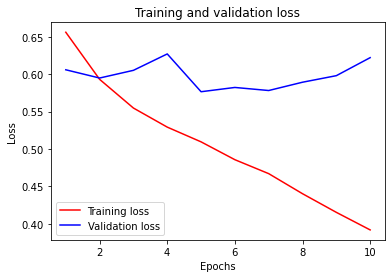

In [198]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

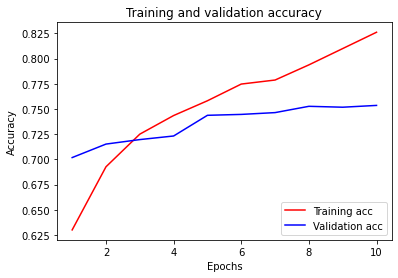

In [199]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()